<a href="https://colab.research.google.com/github/dmgutierrez/webis-clickbait-detector/blob/main/webis_clickbait_newtral.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install spacy_sentence_bert
!pip install wordcloud
!pip install https://github.com/MartinoMensio/spacy-sentence-bert/releases/download/v0.1.2/en_nli_bert_base_max_pooling-0.1.2.tar.gz#en_nli_bert_base_max_pooling-0.1.2
!pip install transformers[torch]
!pip install datasets

  Using cached https://github.com/MartinoMensio/spacy-sentence-bert/releases/download/v0.1.2/en_nli_bert_base_max_pooling-0.1.2.tar.gz (24 kB)


In [2]:
import pandas as pd
import random
import numpy as np
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, f1_score, recall_score
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.utils import class_weight
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from wordcloud import STOPWORDS
import spacy_sentence_bert
import spacy

# Preprocessing Functions

In [3]:
# Functions
# Preprocess Datasets
def simplified_set(df: pd.DataFrame, cols: list):
    """Get only useful columns"""
    df_smpl = df.copy()
    df_smpl = df_smpl[cols]
    return df_smpl

def clean_set(df: pd.DataFrame, col: str):
    """Cleaning text"""
    df[col].replace({r'[^\x00-\x7F]+': ''}, regex=True, inplace=True)
    print(df.shape)
    df.dropna(axis=0, how="any", thresh=None, subset=None, inplace=True)
    print(df.shape)
    return df

def encoding_target(le: preprocessing.LabelEncoder,df: pd.DataFrame, 
                    target_col: str, text_col: str, target_num_col: str,
                    fit: bool = True,
                    dataset_label_col: str = "labels",
                    dataset_text_col: str = "text"):
    """
    Encoding Labels
    """
    if fit:
        le.fit(df[target_col])
    print(le.classes_)
    target_num_tr = le.transform(df[target_col])
    df[target_num_col] = target_num_tr

    df.rename(columns={target_num_col: dataset_label_col, text_col: dataset_text_col}, inplace=True)
    df[dataset_label_col] = df[dataset_label_col].astype("int")
    df[dataset_text_col] = df[dataset_text_col].astype("string")

    return df, le



def create_wordcloud(text: str, stopwords: set):
    wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)
    plt.figure( figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

# Explore Dataset

In [4]:
# Load Data
webis_train = pd.read_csv('webis_train.csv')
webis_test = pd.read_csv('webis_test.csv')
le = preprocessing.LabelEncoder()

cols: list =["postText", "truthClass"]

df_train_simplified: pd.DataFrame = simplified_set(df=webis_train, cols=cols)
df_test_simplified: pd.DataFrame = simplified_set(df=webis_test, cols=cols)
df_train_simplified.head()

,postText,truthClass
0,UK’s response to modern slavery leaving victim...,no-clickbait
1,this is good,clickbait
2,"The ""forgotten"" Trump roast: Relive his brutal...",no-clickbait
3,Meet the happiest #dog in the world!,clickbait
4,Tokyo's subway is shut down amid fears over an...,no-clickbait


In [5]:
df_train = clean_set(df=df_train_simplified, col="postText")
df_test = clean_set(df=df_test_simplified, col="postText")

df_train_cl, le = encoding_target(le=le,df=df_train, target_col="truthClass",
                              text_col="postText",
                              target_num_col="truthClass_label", fit = True)

df_test_cl, le = encoding_target(le=le,df=df_test, target_col="truthClass",
                              text_col="postText",
                              target_num_col="truthClass_label", fit = False)

(19538, 2)
(19484, 2)
(18979, 2)
(18913, 2)
['clickbait' 'no-clickbait']
['clickbait' 'no-clickbait']


In [6]:
df_train_cl.head()

,text,truthClass,labels
0,UKs response to modern slavery leaving victims...,no-clickbait,1
1,this is good,clickbait,0
2,"The ""forgotten"" Trump roast: Relive his brutal...",no-clickbait,1
3,Meet the happiest #dog in the world!,clickbait,0
4,Tokyo's subway is shut down amid fears over an...,no-clickbait,1


In [7]:
freqs_target = Counter(df_train_cl['truthClass'].values.flatten().tolist()
)
freqs_target

Counter({'clickbait': 4716, 'no-clickbait': 14768})

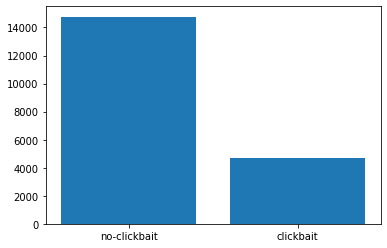

In [8]:
# Plot label distribution 
plt.bar(freqs_target.keys(), freqs_target.values())
plt.show()

Since the dataset is totally imbalanced, let's compute the some class weights to be considered when evaluating the model.

In [9]:
# Create wordcloud

df_train_pos_cl = df_train_cl[df_train_cl['labels'] == 0] # clickbait
df_train_neg_cl = df_train_cl[df_train_cl['labels'] == 1] # No-clickbait

text_pos = " ".join(i for i in df_train_pos_cl.text)
text_neg = " ".join(i for i in df_train_neg_cl.text)

stopwords = set(STOPWORDS)

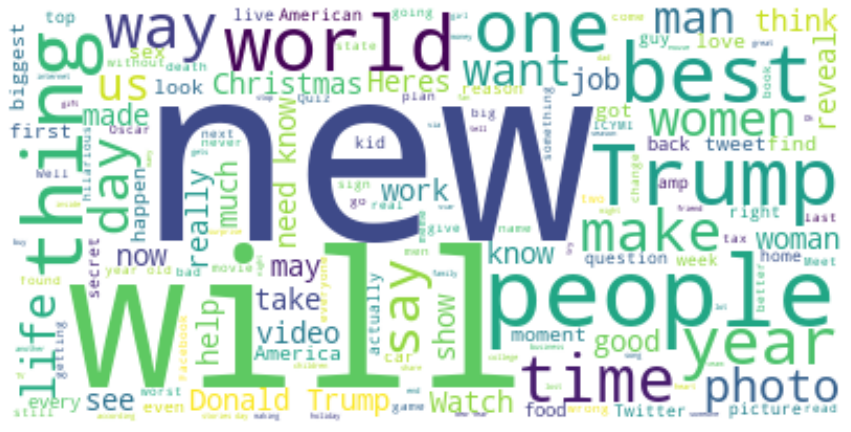

In [10]:
create_wordcloud(text_pos, stopwords=stopwords)

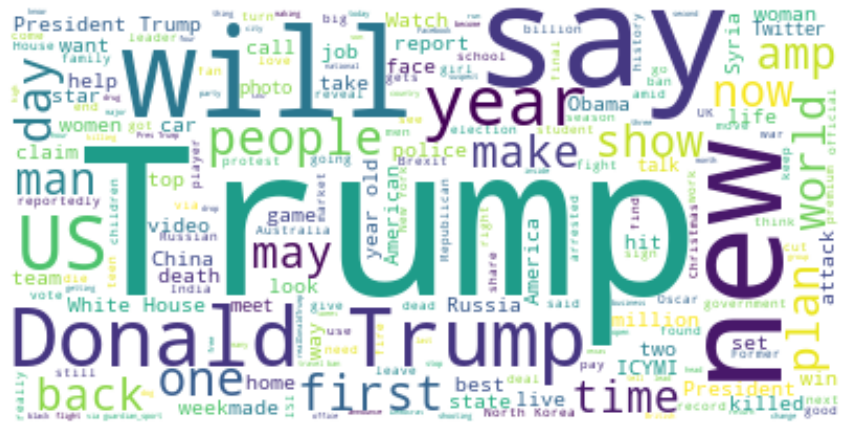

In [11]:
create_wordcloud(text_neg, stopwords=stopwords)

In [12]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  classes=np.unique(df_train_cl['labels']),
                                                  y=df_train_cl['labels']).tolist()

# Extract Embeddings

In [13]:
# Load English sentence model from SPACY
nlp = spacy.blank('en')
nlp.add_pipe('sentence_bert', config={'model_name': 'allenai-specter'})


In [ ]:
# Extract vectors for both training and testing sets
df_train_cl['vector'] = df_train_cl['text'].apply(lambda x: nlp(x).vector)
df_test_cl['vector'] = df_test_cl['text'].apply(lambda x: nlp(x).vector)

In [ ]:
# Create train and test sets from the vectors
X_train = np.array(df_train_cl['vector'].tolist())
X_test = np.array(df_test_cl['vector'].tolist())

In [ ]:
y_train = df_train_cl['labels']
y_test = df_test_cl['labels']

In [ ]:
# 1: no-clickbait, 0: clickbait
sample_weight = [class_weights[0] if i == 0 else class_weights[1] for i in y_test]


# Create classifier on top of embeddings

In [ ]:
clf = SVC(gamma='auto')

In [ ]:
# Train the model
clf.fit(X_train, y_train)

In [ ]:
# Make inference for test set
y_pred = clf.predict(X_test)

In [ ]:
# Compute classification metrics
print(balanced_accuracy_score(y_true=y_test, y_pred=y_pred, sample_weight=sample_weight))
print(f1_score(y_true=y_test, y_pred=y_pred, sample_weight=sample_weight,
               average='weighted'))
print(recall_score(y_true=y_test, y_pred=y_pred, sample_weight=sample_weight,
                   average='weighted'))

# Analyse some of the erros of the model

In [ ]:
err_indx = [i for i, pred in enumerate(y_pred) if y_test[i] != pred]

test_records = df_test[['text', 'labels']].to_dict('records')
err_test_records = [rec for i, rec in enumerate(test_records) if i in err_indx]
for record in random.sample(test_records, k=5):
  print(record)

# Finetune Pre-trained model

## Generate Dataset schema for HuggingFace

In [ ]:
# Split train into train + eval
webis_clickbait_train, webis_clickbait_eval = train_test_split(df_train_cl, 
                                                               test_size=0.3,
                                                               stratify=df_train_cl['labels'])
webis_clickbait_train.shape, webis_clickbait_eval.shape

In [ ]:
# Convert Pandas to Dataset
tds = Dataset.from_pandas(webis_clickbait_train)
vds = Dataset.from_pandas(webis_clickbait_eval)
ts = Dataset.from_pandas(df_test_cl)
tds, vds, ts

In [ ]:
# Build Dataset
webis_clickbait_ds = DatasetDict()

webis_clickbait_ds['train'] = tds
webis_clickbait_ds['validation'] = vds
webis_clickbait_ds['test'] = ts

webis_clickbait_ds

## Tokenize Data

In [ ]:
# Pre-trained Model
model_name: str = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def preprocess_function(samples, colname="text"):
    #print(samples[colname][0])
    return tokenizer(samples[colname], truncation=True,padding=True)

In [ ]:
# Sanity check
tokenized_sentences_1 = tokenizer(webis_clickbait_ds["train"]["text"][0], truncation=True)
tokenized_sentences_1

In [ ]:
# Get tokenized input data
tokenized_webis_clickbait = webis_clickbait_ds.map(preprocess_function, batched=True)
tokenized_webis_clickbait

In [ ]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

## Fine-tune Pre-trained Model

In [ ]:
# Load pre-trained model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

In [ ]:
# Add Parameters to Trainer object
output_dir="./results"
learning_rate=2e-5
per_device_train_batch_size=16
per_device_eval_batch_size=16
num_train_epochs=1
weight_decay=0.01

training_args = TrainingArguments(
    output_dir=output_dir,
    learning_rate=learning_rate,
    per_device_train_batch_size=per_device_train_batch_size,
    per_device_eval_batch_size=per_device_eval_batch_size,
    num_train_epochs=num_train_epochs,
    weight_decay=weight_decay,
    evaluation_strategy="epoch"
)

In [ ]:
# Create trainer object
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_webis_clickbait["train"],
    eval_dataset=tokenized_webis_clickbait["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)
trainer

In [ ]:
# Train the model
trainer.train()